# Chapter 18. Gaussian Processes

## Chapter 18.1 Introduction to Gaussian Processes

* A Gaussian process represents a distribution over functions by specifying a multivariate normal (Gaussian) distribution over all possible function values. It is possible to easily manipulate Gaussian distributions to find the distribution of one function value based on the values of any set of other values. In other words, if we observe a set of points, then we can condition on these points and infer a distribution over what the value of the function might look like at any other input. How we model the correlations between these points is determined by the covariance function and is what defines the generalization properties of the Gaussian process. While it takes time to get used to Gaussian processes, they are easy to work with, have many applications, and help us understand and develop other model classes, like neural networks.

## Chapter 18.2 Gaussian Processes Priors

In [3]:
import numpy as np
from scipy.spatial import distance_matrix
from d2l import torch as d2l

In [4]:
d2l.set_figsize()

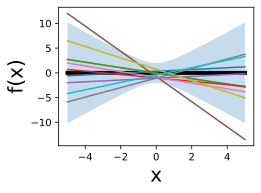

In [5]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds

x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points ** 2))
up_bd = 2 * np.sqrt((1 + x_points ** 2))

d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("f(x)", fontsize=20)
d2l.plt.show()

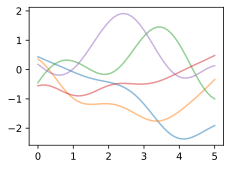

In [6]:
def rbfkernel(x1, x2, ls=4.):
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp(-(1. / ls / 2) * (dist ** 2))

x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points, x_points, 1)

prior_samples = np.random.multivariate_normal(meanvec, covmat, size=5)
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()

## Chapter 18.3 Gaussian Process Inference

In [8]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 6.8 MB/s eta 0:00:00


In [9]:
import math
import os
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix
from d2l import torch as d2l

In [10]:
d2l.set_figsize()

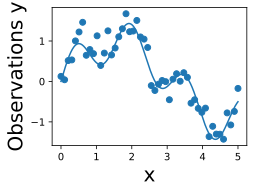

In [11]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.)

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y)
d2l.plt.xlabel('x', fontsize=20)
d2l.plt.ylabel('Observations y', fontsize=20)
d2l.plt.show()

In [13]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    K = d2l.rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ \
        np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * \
                                        np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2. * np.log(2 * np.pi)
    
    return -(kernel_term + logdet + const)

learned_hypers = optimize.minimize(neg_MLL, x0=np.array([ell_est, post_sig_est]),
                                      bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]

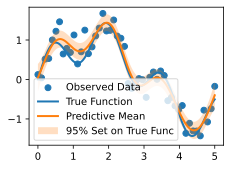

In [15]:
K_x_xstar = d2l.rbfkernel(train_x, test_x, ls=ell)
K_x_x = d2l.rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = d2l.rbfkernel(test_x, test_x, ls=ell)

post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x + \
                                        post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ train_y

post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x + \
                                        post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ K_x_xstar

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
d2l.plt.legend(['Observed Data', 'True Function', 'Predictive Mean', '95% Set on True Func'])
d2l.plt.show()

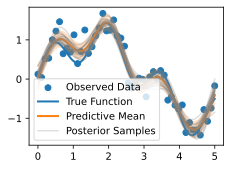

In [16]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', 'Posterior Samples'])
d2l.plt.show()

In [17]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

class ExactGPModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [19]:
for i in range(training_iter):
    optimizer.zero_grad()
    
    output = model(train_x)
    
    loss = -mll(output, train_y)
    loss.backward()
    
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
             f'squared lengthscale: '
             f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
             f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 0.982 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.724 squared lengthscale: 1.311 noise variance: 0.315
Iter 21/50 - Loss: 0.625 squared lengthscale: 1.507 noise variance: 0.146
Iter 31/50 - Loss: 0.639 squared lengthscale: 1.616 noise variance: 0.121
Iter 41/50 - Loss: 0.625 squared lengthscale: 1.568 noise variance: 0.158


In [21]:
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

/tmp/ipykernel_9890/2719653561.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x = torch.tensor(test_x)


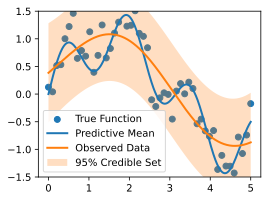

In [23]:
with torch.no_grad():
    f, ax = d2l.plt.subplots(1, 1, figsize=(4, 3))
    
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['True Function', 'Predictive Mean', 'Observed Data', '95% Credible Set'])

* GPyTorch is a Gaussian process library implemented using PyTorch. GPyTorch is designed for creating scalable, flexible, and modular Gaussian process models with ease.